<a href="https://colab.research.google.com/github/utxu/TFM_food_recognition/blob/main/colab_vgg16_FE_noaugmen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.2 GB  | Proc size: 947.9 MB
GPU RAM Free: 14887MB | Used: 222MB | Util   1% | Total 15109MB


In [ ]:
!kill -9 -1 # si l aúltima linea en 'Util' es mayor que el 0%, trata de apagar la máquina para la asignación de otra

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!pwd

/content


In [ ]:
import os

# Location of Zip File
drive_path = '/content/drive/MyDrive/spanish_food_images.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'spanish_food_images.zip'

In [ ]:
!ls

drive  sample_data  spanish_food_images  spanish_food_images.zip


In [ ]:
# Vamos a borrar la copia del .zip porq lo tenemos en la ruta de 'My drive'
! rm -rf spanish_food_images.zip

In [ ]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
conv_base = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(150,150,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pwd

/content


In [ ]:
base_dir = '/content/spanish_food_images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [ ]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 4))
    generator = datagen.flow_from_directory(directory, 
                                           target_size=(150, 150), 
                                           batch_size = batch_size, 
                                           class_mode = "categorical")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 4 classes.


In [ ]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 4 classes.


In [ ]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 4 classes.


In [ ]:
train_features.shape

(2000, 4, 4, 512)

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4), 
              metrics=['acc'])

history = model.fit(train_features, train_labels, 
                   epochs = 30, 
                   batch_size = 20, 
                   validation_data = (validation_features, validation_labels))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
100/100 [==============================] - 7s 8ms/step - loss: 1.2734 - acc: 0.4600 - val_loss: 0.6645 - val_acc: 0.7500
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6354 - acc: 0.7489 - val_loss: 0.5726 - val_acc: 0.7660
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.5226 - acc: 0.8034 - val_loss: 0.5420 - val_acc: 0.7890
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4269 - acc: 0.8469 - val_loss: 0.5051 - val_acc: 0.8020
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3581 - acc: 0.8570 - val_loss: 0.5275 - val_acc: 0.7860
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2912 - acc: 0.8945 - val_loss: 0.5278 - val_acc: 0.7960
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2579 - acc: 0.9197 - val_loss: 0.5121 - val_acc: 0.8070
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

In [ ]:
import matplotlib.pyplot as plt

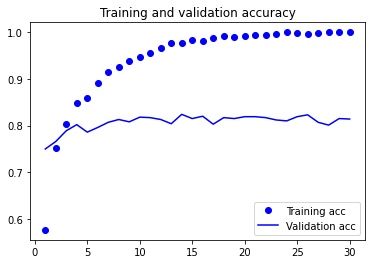

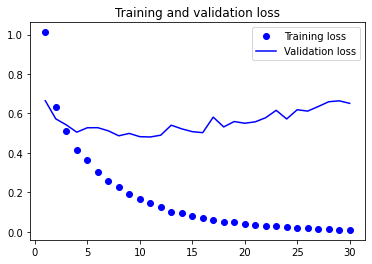

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()